# Vamos a probar manga OCR

In [4]:
! pip install manga-ocr

In [2]:
! pip install inference-sdk

Ejemplo aplicado a un segmento almacenado en local

In [1]:
import PIL.Image
from manga_ocr import MangaOcr

mocr = MangaOcr()

img = PIL.Image.open('/home/carol/code/cparran/MOJI/raw_data/01.jpg')
text = mocr(img)
text

KeyboardInterrupt: 

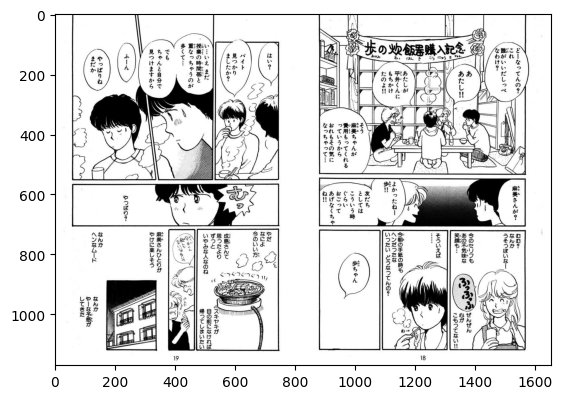

In [9]:
import os
import PIL.Image
from manga_ocr import MangaOcr
import matplotlib.pyplot as plt
import numpy as np

IMAGES_PATH = os.path.join('..', 'data', 'Manga109s', 'Manga109s_released_2023_12_07', 'images', 'AisazuNihaIrarenai')

img = np.asarray(PIL.Image.open(os.path.join(IMAGES_PATH, '009.jpg')))

plt.imshow(img)


In [2]:
from xml.etree import ElementTree as ET
import os

PATH = os.path.join('..', 'data', 'Manga109s', 'Manga109s_released_2023_12_07', 'annotations')

tree = ET.parse(os.path.join(PATH, 'AisazuNihaIrarenai.xml'))
root = tree.getroot()

In [3]:
data = []

for i, pages in enumerate(root[1]):

    page = {}
    page['page'] = i

    bubbles = []

    for elem in pages:

        if elem.tag == 'text':

            info = elem.attrib
            info['text'] = elem.text

            bubbles.append(info)

    page['bubbles'] = bubbles

    data.append(page)

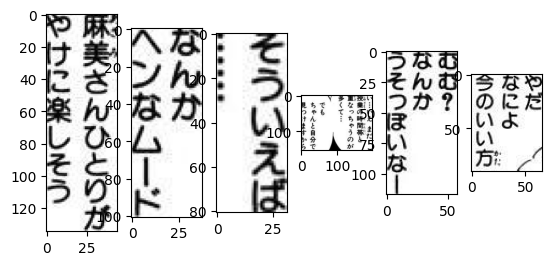

In [11]:
fig, axs = plt.subplots(1, 6)

images = []

for i, bubble in enumerate(data[9]['bubbles'][:6]):

    xmin = int(bubble['xmin'])
    xmax = int(bubble['xmax'])
    ymin = int(bubble['ymin'])
    ymax = int(bubble['ymax'])

    axs[i].imshow(img[ymin:ymax, xmin:xmax])

    images.append(img[ymin:ymax, xmin:xmax])


In [12]:
images

[array([[[250, 250, 250],
         [255, 255, 255],
         [246, 246, 246],
         ...,
         [192, 192, 192],
         [174, 174, 174],
         [210, 210, 210]],
 
        [[ 70,  70,  70],
         [100, 100, 100],
         [250, 250, 250],
         ...,
         [ 34,  34,  34],
         [  3,   3,   3],
         [107, 107, 107]],
 
        [[ 40,  40,  40],
         [ 25,  25,  25],
         [178, 178, 178],
         ...,
         [ 10,  10,  10],
         [ 29,  29,  29],
         [ 29,  29,  29]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [17]:
def ocr_bubble_text(image):

    mocr = MangaOcr()

    image_format = PIL.Image.fromarray(image)

    # Realizar la operación de OCR en la imagen
    text = mocr(image_format)

    return text

In [19]:
print(ocr_bubble_text(images[3]))

2024-03-08 14:26:00.391 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-08 14:26:05.854 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-08 14:26:09.088 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


い．．．いえまだ授業の時間帯と量なっちゃうのが多くて．．．でもちゃんと自分で見つけますから


Ejemplo aplicado a una imagen alojada online

In [54]:
import requests
from PIL import Image
from io import BytesIO
from manga_ocr import MangaOcr

mocr = MangaOcr()

# URL de la imagen
url = 'https://raw.githubusercontent.com/kha-white/manga-ocr/master/assets/examples/01.jpg'

# Descargar la imagen desde la URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Realizar la operación de OCR en la imagen
text = mocr(img)
print(text)


2024-03-07 12:33:49.973 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-07 12:33:55.823 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-07 12:33:59.700 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


立川で見た〝穴〟の下の巨大な眼は：


Combinaremos manga-ocr con los resultados arrojados por nuestro modelo en Roboflow

In [56]:
! pip install inference-sdk

Test 1: OCR on a double page

In [1]:
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from inference_sdk import InferenceHTTPClient

# Define la ruta de la imagen
img_path = '/home/carol/code/cparran/MOJI/raw_data/Nana v01/005.jpg'

# Inicializar el cliente
CLIENT = InferenceHTTPClient(
    api_url="http://detect.roboflow.com",
    api_key="JVuvSUZ2T8BQEtoGVvtv"
)

# Inferir en la imagen local
result = CLIENT.infer(img_path, model_id="manga-text-detection/2")

# Carga la imagen
img = Image.open(img_path)

# Segments
segments = result['predictions']

# Función para aplicar OCR a un segmento de imagen
def ocr_segment(image, segment):
    left = segment['x'] - segment['width'] / 2
    top = segment['y'] - segment['height'] / 2
    right = left + segment['width']
    bottom = top + segment['height']

    left = max(left, 0)
    top = max(top, 0)

    crop_img = image.crop((left, top, right, bottom))
    text = pytesseract.image_to_string(crop_img, lang='jpn')

    return text.strip()

# Itera sobre los segmentos, aplica OCR y almacena el texto en cada segmento
fig, ax = plt.subplots(1)
ax.imshow(img)

for segment in segments:
    text = ocr_segment(img, segment)
    segment['text'] = text  # Almacenar el texto detectado en el segmento

    # Dibujar rectángulo alrededor del segmento
    x, y, w, h = segment['x'], segment['y'], segment['width'], segment['height']
    rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Mostrar la imagen con los segmentos
# Mostrar la imagen en escala de grises
plt.imshow(img, cmap='gray')
plt.show()

# Imprimir el texto detectado y las coordenadas de cada segmento
for segment in segments:
    print(f"Texto: {segment['text']}, Coordenadas: ({segment['x']}, {segment['y']}, {segment['width']}, {segment['height']})")


ModuleNotFoundError: No module named 'pytesseract'

In [39]:
result

{'time': 0.25090211699989595,
 'image': {'width': 1530, 'height': 1200},
 'predictions': [{'x': 886.0253906250001,
   'y': 1004.8095703125001,
   'width': 119.53125000000001,
   'height': 153.896484375,
   'confidence': 0.9692835807800293,
   'class': 'text_bubble',
   'class_id': 0,
   'detection_id': 'a767a190-30d1-4d4f-8a68-7a9c955ff938',
   'text': ''},
  {'x': 1131.064453125,
   'y': 221.87988281250003,
   'width': 206.19140625000003,
   'height': 231.59179687500003,
   'confidence': 0.9683305025100708,
   'class': 'text_bubble',
   'class_id': 0,
   'detection_id': 'cc2da00b-4f29-4170-9b8e-c3912f68f268',
   'text': ''},
  {'x': 620.8154296875,
   'y': 980.1562500000001,
   'width': 180.791015625,
   'height': 230.09765625000003,
   'confidence': 0.9678751826286316,
   'class': 'text_bubble',
   'class_id': 0,
   'detection_id': 'd9d9d553-81eb-464a-8cd1-4fe2df1f063d',
   'text': ''},
  {'x': 100.107421875,
   'y': 668.6279296875,
   'width': 164.35546875,
   'height': 207.68554687

Test 2: OCR on a single page con mejoras en ocr_segment

findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

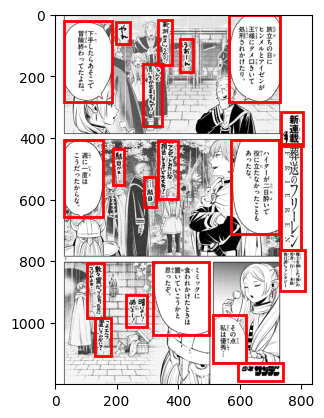

Texto: 料 あ役*ハ
留 つにイ
た 立:夕
なた |
"な が
か
つ 日>
た 酔:
こい
.    と で
)   も
4        。, Coordenadas: (649.8046875, 558.984375, 155.859375, 304.6875)
Texto: 冒下^   」

険%手ょ

終とし

わ た

つ ら

て あ

た そ

よこ
い   ね て    へ, Coordenadas: (107.2265625, 151.7578125, 155.859375, 261.328125)
Texto: 処:王上 旅5
刑様:ン 立ょ
きにメち
れ タルの
か ズメ と日>
け ロア に
た き イ

A りいでゼ

品  9 て ン

)      が

?         ., Coordenadas: (646.875, 142.3828125, 164.0625, 282.421875)
Texto: レー NG
こ 週5
う に
だ 一\
つ 度と
た は
か
ら
| な
AN “     4, Coordenadas: (91.9921875, 531.4453125, 125.39062499999999, 249.60937499999997)
Texto: 私#を V
は の

優5点:
秀*, Coordenadas: (567.7734375, 1052.9296875, 106.640625, 153.515625)
Texto: | 思?置>食<
っいわミ
たてれッ
ぞ いか グクグ

い    こけに

て    う た

*1   か と

還   と き

: .        は, Coordenadas: (409.5703125, 922.2656249999999, 183.984375, 236.71874999999997)
Texto: 拓

アア
M
il, Coordenadas: (317.578125, 260.15625, 60.93749999999999, 203.90625)
Texto: 後細*魔・
Ji者・E*
各
行司

し
シ た
る 本:後:
? め, Coordenadas: (771.09375, 829.1015625, 79.6875, 132.42

In [47]:
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from inference_sdk import InferenceHTTPClient

# Actualiza la ruta de la imagen
img_path = '/home/carol/code/cparran/MOJI/raw_data/0007.jpg'

# Carga la nueva imagen
img = Image.open(img_path)


# Inicializar el cliente
CLIENT = InferenceHTTPClient(
    api_url="http://detect.roboflow.com",
    api_key="JVuvSUZ2T8BQEtoGVvtv"
)

# Inferir en la imagen local
result = CLIENT.infer(img_path, model_id="manga-text-detection/2")

# Carga la imagen
img = Image.open(img_path)

# Segments
segments = result['predictions']

# Función para aplicar OCR a un segmento de imagen
def ocr_segment(image, segment):
    left = segment['x'] - segment['width'] / 2
    top = segment['y'] - segment['height'] / 2
    right = left + segment['width']
    bottom = top + segment['height']

    left = max(left, 0)
    top = max(top, 0)

    # Recorta y escala la imagen
    crop_img = image.crop((left, top, right, bottom)).convert('L')  # Convierte a escala de grises
    crop_img = crop_img.resize((int(crop_img.width * 2), int(crop_img.height * 2)), Image.LANCZOS)  # Usa Image.LANCZOS en lugar de Image.ANTIALIAS

    # Aplica binarización
    threshold = 128
    crop_img = crop_img.point(lambda p: p > threshold and 255)

    # Aplica OCR usando opciones optimizadas
    config = '--oem 3 --psm 6'
    text = pytesseract.image_to_string(crop_img, lang='jpn', config=config)

    return text.strip()

# Itera sobre los segmentos, aplica OCR y almacena el texto en cada segmento
fig, ax = plt.subplots(1)
ax.imshow(img)

for segment in segments:
    text = ocr_segment(img, segment)
    segment['text'] = text  # Almacenar el texto detectado en el segmento

    # Dibujar rectángulo alrededor del segmento
    x, y, w, h = segment['x'], segment['y'], segment['width'], segment['height']
    rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Mostrar la imagen con los segmentos
# Mostrar la imagen en escala de grises
plt.imshow(img, cmap='gray')
plt.show()

# Imprimir el texto detectado y las coordenadas de cada segmento
for segment in segments:
    print(f"Texto: {segment['text']}, Coordenadas: ({segment['x']}, {segment['y']}, {segment['width']}, {segment['height']})")


In [48]:
result

{'time': 0.29663865099996656,
 'image': {'width': 836, 'height': 1200},
 'predictions': [{'x': 649.8046875,
   'y': 558.984375,
   'width': 155.859375,
   'height': 304.6875,
   'confidence': 0.9873644113540649,
   'class': 'text_bubble',
   'class_id': 0,
   'detection_id': 'dad842bd-94d0-4de9-9d93-b7fca3f65dac',
   'text': '料 あ役*ハ\n留 つにイ\nた 立:夕\nなた |\n"な が\nか\nつ 日>\nた 酔:\nこい\n.    と で\n)   も\n4        。'},
  {'x': 107.2265625,
   'y': 151.7578125,
   'width': 155.859375,
   'height': 261.328125,
   'confidence': 0.9818589091300964,
   'class': 'text_bubble',
   'class_id': 0,
   'detection_id': '8638caac-2cd1-42e2-90f9-10476b605dc9',
   'text': '冒下^   」\n\n険%手ょ\n\n終とし\n\nわ た\n\nつ ら\n\nて あ\n\nた そ\n\nよこ\nい   ね て    へ'},
  {'x': 646.875,
   'y': 142.3828125,
   'width': 164.0625,
   'height': 282.421875,
   'confidence': 0.9807508587837219,
   'class': 'text_bubble',
   'class_id': 0,
   'detection_id': '199373c3-6dfe-4157-bc9e-0d63c54da656',
   'text': '処:王上 旅5\n刑様:ン 立ょ\nきにメち\nれ タルの\nか

Manga-ocr se comporta super bien con segmentos de imagenes, pero no tiene los mismos resultados como páginas completas de manga.